# Лабораторная 6 - Catboost, Фида А.Д. 6135

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from collections import Counter

import catboost
from catboost import *
from catboost import datasets

from sklearn.metrics import log_loss, accuracy_score, plot_confusion_matrix, \
f1_score, recall_score, precision_score, confusion_matrix, mean_squared_error, median_absolute_error, roc_curve

import seaborn as sns

plt.rcParams["figure.figsize"] = (16, 10)
np.random.seed(42)

## CatBoostClassifier

### 1. Применить классификатор CatBoostClassifier к вашему датасету (бинарная или multiclass классификация по желанию). Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы. Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss. Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).

#### Soybean dataset

Характеристики 58 разновидностей сои, выращенной в четырёх районах Австралии

- env      - Комбинированный фактор с 8 уровнями [B, L, N, R - район; 70, 71 - год]
- loc      - Четыре района Австралии [Brookstead, Lawes, Nambour, RedlandBay]
- year     - Год [1970, 1971]
- gen      - Генотип сои [G01, G02, ..., G58]
- yield    - Урожайность [тонн/гектар]
- height   - Средняя высота растений [метров]
- lodging  - Полегание [%]
- size     - Средний размер бобов [миллиметров]
- protein  - Среднее содержание белка [%]
- oil      - Среднее содержание жира [%] -->

In [97]:
data = pd.read_table('data/01-soybean.txt', skiprows=30, sep=r'\s+').sample(frac=1.)
data.head()

env         loc  year  gen  yield  height  lodging   size  protein  \
10   L70       Lawes  1970  G10  2.984   1.155     3.75  10.85    39.70   
31   L70       Lawes  1970  G31  2.562   1.220     3.75   8.55    39.35   
40   L70       Lawes  1970  G40  1.556   1.205     4.00   9.25    41.20   
444  R71  RedlandBay  1971  G38  1.515   0.785     2.00   7.70    42.70   
267  L71       Lawes  1971  G35  2.495   0.970     1.75   7.75    41.15   

        oil  
10   20.430  
31   20.165  
40   19.625  
444  17.285  
267  18.155

In [98]:
data.shape

(464, 10)

In [99]:
le = LabelEncoder()
le.fit(data['year'])
data['year'] = le.transform(data['year'])
set(data['year'])

{0, 1}

In [100]:
one_hot = pd.get_dummies(data['loc'])

data = data.drop('loc', axis=1)

data = data.join(one_hot)
data  

env  year  gen  yield  height  lodging   size  protein     oil  \
10   L70     0  G10  2.984   1.155     3.75  10.85    39.70  20.430   
31   L70     0  G31  2.562   1.220     3.75   8.55    39.35  20.165   
40   L70     0  G40  1.556   1.205     4.00   9.25    41.20  19.625   
444  R71     1  G38  1.515   0.785     2.00   7.70    42.70  17.285   
267  L71     1  G35  2.495   0.970     1.75   7.75    41.15  18.155   
..   ...   ...  ...    ...     ...      ...    ...      ...     ...   
107  B70     0  G49  2.810   1.070     2.50  20.00    37.25  21.825   
271  L71     1  G39  2.608   0.940     1.75   8.25    42.15  18.335   
349  N71     1  G01  2.097   0.725     1.25   7.30    38.50  19.285   
436  R71     1  G30  1.103   0.965     2.50   5.90    48.00  15.970   
103  B70     0  G45  2.789   0.775     1.75  22.10    35.85  22.175   

     Brookstead  Lawes  Nambour  RedlandBay  
10            0      1        0           0  
31            0      1        0           0  
40            0      1        0           0  
444           0      0        0           1  
267           0      1        0           0  
..          ...    ...      ...         ...  
107           1      0        0           0  
271           0      1        0           0  
349           0      0        1           0  
436           0      0        0           1  
103           1      0        0           0  

[464 rows x 13 columns]

In [101]:
raw_data = data.drop(['gen', 'env', 'year'], axis=1)
labels = data['year']

In [102]:
val_size = len(raw_data) // 2
test_size = int(val_size * 0.25) 

Xtrain = raw_data[:val_size]
Ytrain = labels[:val_size]

Xval = raw_data[val_size:val_size + test_size]
Yval = labels[val_size:val_size + test_size]

Xtest = raw_data[val_size + test_size:]
Ytest = labels[val_size + test_size:]

In [103]:
len(Xtrain), len(Xval), len(Xtest)

(232, 58, 174)

In [104]:
Counter(Ytrain)

Counter({0: 123, 1: 109})

#### Build the model

In [105]:
# cat_features = [0]

# train_dataset = Pool(data=Xtrain,
#                      label=Ytrain,
#                      cat_features=cat_features)

eval_dataset = Pool(data=Xval,
                    label=Yval,
                    cat_features=None)

# Initialize CatBoostClassifier
model = CatBoostClassifier(learning_rate=0.03,
                           eval_metric='AUC')

model.fit(Xtrain,
          Ytrain,
          eval_set=eval_dataset,
          use_best_model=True,
          verbose=False)

print("best iteration", model.get_best_iteration())

best iteration 69


In [106]:
y_pred = model.predict(Xtest)

keys = {
    'accuracy_score': [accuracy_score(Ytest, y_pred)],
    'precision_score': [precision_score(Ytest, y_pred)],
    'recall_score': [recall_score(Ytest, y_pred)],
    'f1_score': [f1_score(Ytest, y_pred)],
}
metrics = pd.DataFrame(data=keys, index=['values'])
metrics

accuracy_score  precision_score  recall_score  f1_score
values        0.862069         0.910256      0.806818  0.855422

### 3. Для бинарного классификатора на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

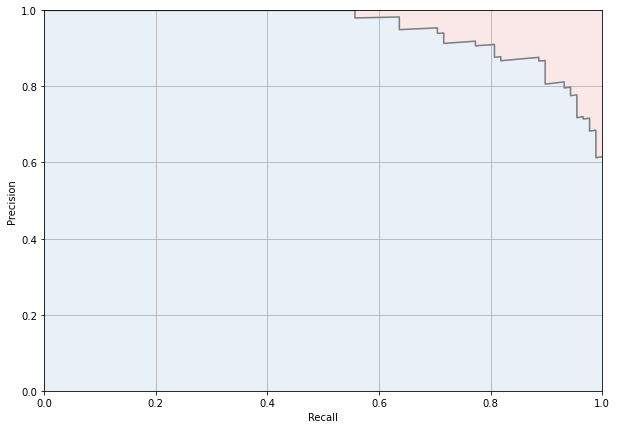

In [113]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


y_pred_proba = model.predict_proba(Xtest)
y_pred_proba = list(map(lambda x: x[1], y_pred_proba))
precision, recall, threshold = precision_recall_curve(Ytest, y_pred_proba)

f1 = [2 * (p * r) / (p + r) for p, r in zip(precision, recall)]

plt.rcParams['figure.figsize'] = (10, 7)
plt.plot(recall, precision, color='tab:gray')
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.fill_between(x=recall, y1=precision, color='tab:blue', alpha=0.1)
plt.fill_between(x=recall, y1=precision, y2=1.0, color='tab:red', alpha=0.1)

plt.xlim(0, 1.0)
plt.ylim(0, 1.0);

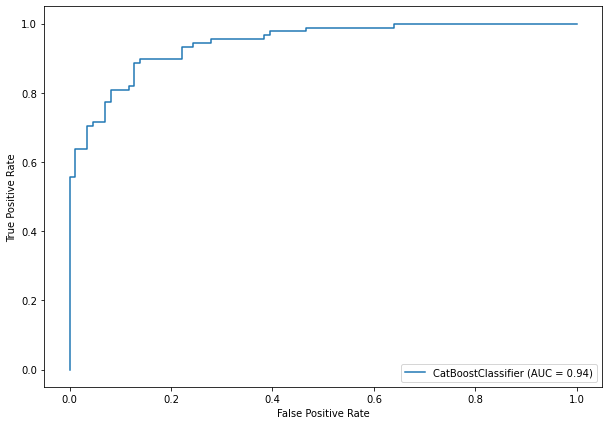

In [116]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, Xtest, Ytest);

## CatBoostRegressor

### 2. Применить регрессию CatBoostRegressor к датасету (датасет уже другой, для регрессии, естественно). Вывести номер итерации с значения метрик (MAE и MSE) для наилучшей итерации.

- age 
- sex 
- chest pain type (4 values) 
- resting blood pressure 
- serum cholestoral in mg/dl 
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved 
- exercise induced angina 
- oldpeak = ST depression induced by exercise relative to rest 
- the slope of the peak exercise ST segment 
- number of major vessels (0-3) colored by flourosopy 
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [87]:
df = pd.read_csv('data/heart.csv')
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

Целевая переменная - age

In [88]:
raw_data = df.drop(['age'], axis=1)
labels = df['age']

In [89]:
val_size = len(raw_data) // 2
test_size = int(val_size * 0.25) 

Xtrain = raw_data[:val_size]
Ytrain = labels[:val_size]

Xval = raw_data[val_size:val_size + test_size]
Yval = labels[val_size:val_size + test_size]

Xtest = raw_data[val_size + test_size:]
Ytest = labels[val_size + test_size:]

In [90]:
len(Xtrain), len(Xval), len(Xtest)

(151, 37, 115)

#### Build the model

In [93]:
from catboost import CatBoostRegressor


eval_dataset = Pool(data=Xval,
                    label=Yval,
                    cat_features=None)

# Initialize CatBoostRegressor
model = CatBoostRegressor(learning_rate=1,
                          custom_metric='MAE')

model.fit(Xtrain,
          Ytrain,
          eval_set=eval_dataset,
          use_best_model=True,
          verbose=False)

print("best iteration", model.get_best_iteration())

best iteration 2


In [94]:
y_pred = model.predict(Xtest)

keys = {
    'mean_squared_error': [mean_squared_error(Ytest, y_pred)],
    'median_absolute_error': [median_absolute_error(Ytest, y_pred)]
}
metrics = pd.DataFrame(data=keys, index=['values'])
metrics

mean_squared_error  median_absolute_error
values           67.254138               4.470039

## Выводы

Кэтбуст показал хорошие результаты на датасете для задачи классификации, но не очень хорошо на датасете для задачи регрессии (mse очень велико)